## FKA122: H3 | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd
from IPython.display import display, Markdown

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=20)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 2000

# Functions
def read_data(path):
    data = pd.read_csv(path,delimiter=',',on_bad_lines='skip')
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.fillna(np.nan)
    data = np.asarray(data)
    return data


def save_fig(fig, name, task):
    fig.savefig(f'figs/task_{task}/{name}.pdf', bbox_inches='tight')


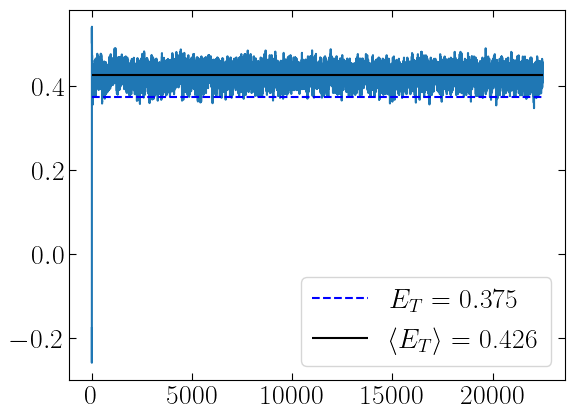

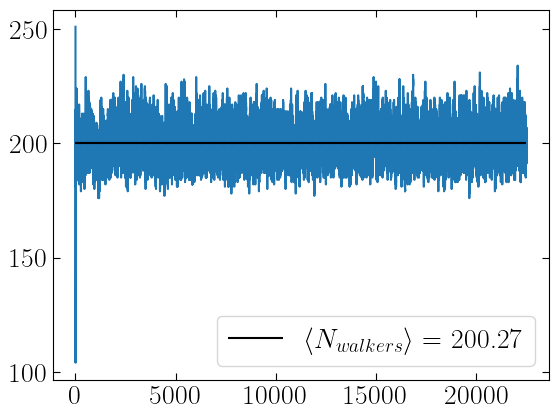

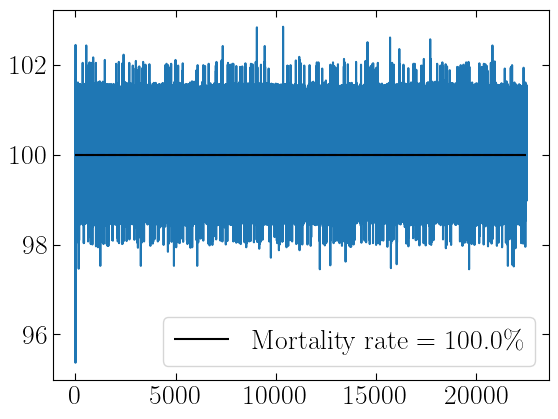

In [59]:
plt.figure()
ET = read_data('ET_Nwalk_non_eq.csv')[:,0]
tau = np.linspace(0, len(ET) * 0.02, len(ET))
plt.plot(tau,ET)
plt.hlines(3/8,0,len(ET) * 0.02,'b',label = f"$E_T={3/8:.3f}$", linestyle = 'dashed')
plt.hlines(np.mean(ET),0,len(ET) * 0.02,colors='k', label = f'$\\langle E_T\\rangle$ = {np.mean(ET):.3f}')
plt.legend()

plt.figure()
walk = read_data('ET_Nwalk_non_eq.csv')[:,1]
plt.plot(tau,walk)
plt.hlines(200,0,np.max(tau),'b', linestyle = 'dashed')
plt.hlines(np.mean(walk),0,np.max(tau),colors ='k', label = '$\\langle N_{walkers}\\rangle$'+f' = {np.mean(walk):.2f}')
plt.legend()

plt.figure()
mortality_rate = read_data('ET_Nwalk_non_eq.csv')[:,2]
plt.plot(tau,mortality_rate)
plt.hlines(100,0,np.max(tau),'b', linestyle = 'dashed')
plt.hlines(np.mean(mortality_rate),0,np.max(tau),colors ='k', label = 'Mortality rate'+f' = {np.mean(mortality_rate):.1f}\\%')
plt.legend()

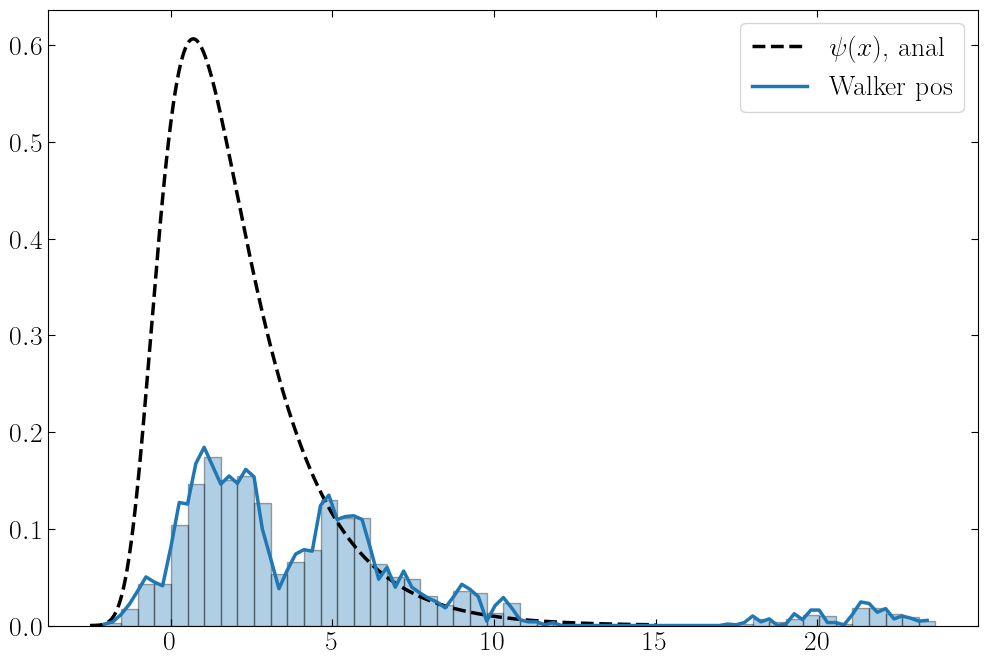

In [50]:
x = np.linspace(-2.5,15,10000)
psi = np.sqrt(2) * np.exp(-np.exp(-x) - x/2)
Morse = 0.5 * (1 - np.exp(-x)) ** 2

plt.figure(figsize=(12,8))
plt.plot(x,psi,label='$\\psi(x)$, anal',color = 'k',lw = 2.5,ls = 'dashed')
walker_pos = read_data('I_was_walkin_in_morse.csv')
walker_pos = walker_pos[~np.isnan(walker_pos)]

counts, bins = np.histogram(walker_pos, bins=100)

# Normalize manually
bin_width = bins[1] - bins[0]  # Width of each bin
normalized_counts = counts / (np.sum(counts) * bin_width)

# Plot the manually normalized histogram
plt.hist(walker_pos,bins=50,density=True,color='tab:blue',alpha=0.35,edgecolor='black')
plt.plot(bins[:-1], normalized_counts, color='tab:blue', lw=2.5, label='Walker pos')

plt.legend()